WNixalo | 20181107

---

The best score achieved by this notebook is **0.92476** pvt @ 237/938 with a threshold of `0.25`.

## Multi-label prediction with Planet Amazon dataset

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from fastai import *
from fastai.vision import *

## Getting the data

The planet dataset isn't available on the [fastai dataset page](https://course.fast.ai/datasets) due to copyright restrictions. You can download it from Kaggle however. Let's see how to do this by using the [Kaggle API](https://github.com/Kaggle/kaggle-api) as it's going to be pretty useful to you if you want to join a competition or use other Kaggle datasets later on.

First, install the Kaggle API by uncommenting the following line and executing it, or by executing it in your terminal (depending on your platform you may need to modify this slightly to either add `source activate fastai` or similar, or prefix `pip` with a path. Have a look at how `conda install` is called for your platform in the appropriate *Returning to work* section of https://course-v3.fast.ai/. (Depending on your environment, you may also need to append "--user" to the command.)

In [ ]:
# ! pip install kaggle --upgrade

Then you need to upload your credentials from Kaggle on your instance. Login to kaggle and click on your profile picture on the top left corner, then 'My account'. Scroll down until you find a button named 'Create New API Token' and click on it. This will trigger the download of a file named 'kaggle.json'.

Upload this file to the directory this notebook is running in, by clicking "Upload" on your main Jupyter page, then uncomment and execute the next two commands (or run them in a terminal).

In [ ]:
#! mkdir -p ~/.kaggle/
#! mv kaggle.json ~/.kaggle/

You're all set to download the data from [planet competition](https://www.kaggle.com/c/planet-understanding-the-amazon-from-space). You just need to go to its main page and accept its rules, and run the two cells below (uncomment the shell commands to download and unzip the data).

In [3]:
path = Config.data_path()/'planet'
path.mkdir(exist_ok=True)
path

PosixPath('/home/jupyter/.fastai/data/planet')

In [ ]:
# ! kaggle competitions download -c planet-understanding-the-amazon-from-space -f train-jpg.tar.7z -p {path}  
# ! kaggle competitions download -c c -f train_v2.csv -p {path}  
# ! unzip -q -n {path}/train_v2.csv.zip -d {path}

We only download the training data file for this lesson, but you can grab the test file if you want to make a late submission.

To extract the content of this file, we'll need 7zip, so uncomment the following line if you need to install it (or run `sudo apt install p7zip` in your terminal).

In [ ]:
# ! conda install -c haasad eidl7zip

And now we can unpack the data (uncomment to run - this might take a few minutes to complete).

In [ ]:
# ! 7za -bd -y -so x {path}/train-jpg.tar.7z | tar xf - -C {path}

In [4]:
path.ls()

[PosixPath('/home/jupyter/.fastai/data/planet/sample_submission_v2.csv'),
 PosixPath('/home/jupyter/.fastai/data/planet/submissions'),
 PosixPath('/home/jupyter/.fastai/data/planet/train_v2.csv'),
 PosixPath('/home/jupyter/.fastai/data/planet/__MACOSX'),
 PosixPath('/home/jupyter/.fastai/data/planet/train-jpg'),
 PosixPath('/home/jupyter/.fastai/data/planet/test_v2_file_mapping.csv'),
 PosixPath('/home/jupyter/.fastai/data/planet/test-jpg-additional'),
 PosixPath('/home/jupyter/.fastai/data/planet/models'),
 PosixPath('/home/jupyter/.fastai/data/planet/test-jpg')]

## Multiclassification

Contrary to the pets dataset studied in last lesson, here each picture can have multiple labels. If we take a look at the csv file containing the labels (in 'train_v2.csv' here) we see that each 'image_name' is associated to several tags separated by spaces.

In [6]:
df = pd.read_csv(path/'train_v2.csv')
df.head()

,image_name,tags
0,train_0,haze primary
1,train_1,agriculture clear primary water
2,train_2,clear primary
3,train_3,clear primary
4,train_4,agriculture clear habitation primary road


To put this in a `DataBunch` while using the [data block API](https://docs.fast.ai/data_block.html), we then need to using `ImageMultiDataset` (and not `ImageClassificationDataset`). This will make sure the model created has the proper loss function to deal with the multiple classes.

In [7]:
tfms = get_transforms(flip_vert=True, max_lighting=0.1, max_zoom=1.05, max_warp=0.)

In [8]:
np.random.seed(42)
src = (ImageFileList.from_folder(path)            
       .label_from_csv('train_v2.csv', sep=' ', folder='train-jpg', suffix='.jpg')  
       .random_split_by_pct(0.2))

In [9]:
data = (src.datasets(ImageMultiDataset)
        .transform(tfms, size=128)
        .databunch().normalize(imagenet_stats))

`show_batch` still works, and show us the different labels separated by `;`.

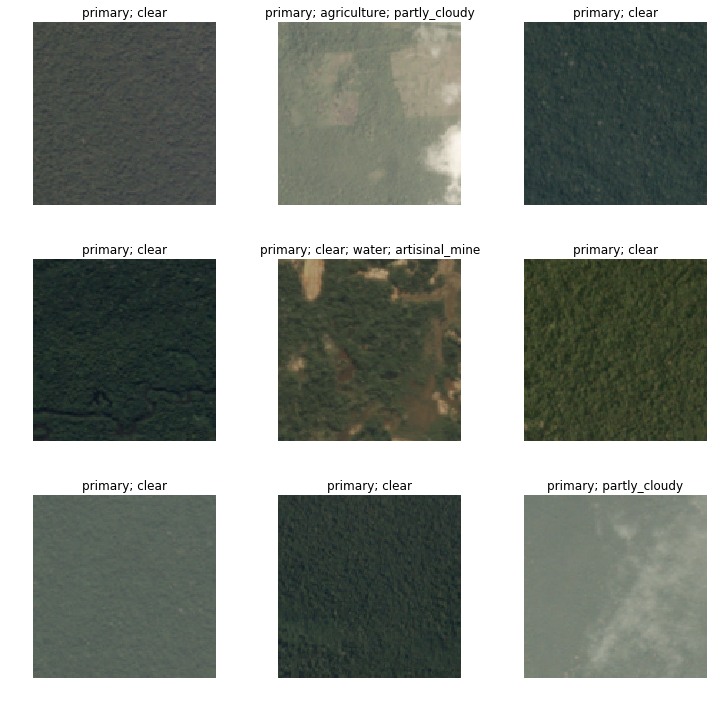

In [10]:
data.show_batch(rows=3, figsize=(10,10))

To create a `Learner` we use the same function as in lesson 1. Our base architecture is resnet34 again, but the metrics are a little bit differeent: we use `accuracy_thresh` instead of `accuracy`. In lesson 1, we determined the predicition for a given class by picking the final activation that was the biggest, but here, each activation can be 0. or 1. `accuracy_thresh` selects the one that are above a certain threshold (0.5 by default) and comapre them to the ground truth.

As for Fbeta, it's the metric that was used by Kaggle on this competition. See [here](https://en.wikipedia.org/wiki/F1_score) for more details.

In [11]:
arch = models.resnet34

In [12]:
f_score = partial(fbeta, thresh=0.2)
learn = create_cnn(data, arch, metrics=[accuracy_thresh, f_score])

We use the LR Finder to pick a good learning rate.

In [14]:
learn.lr_find()

LR Finder complete, type {learner_name}.recorder.plot() to see the graph.


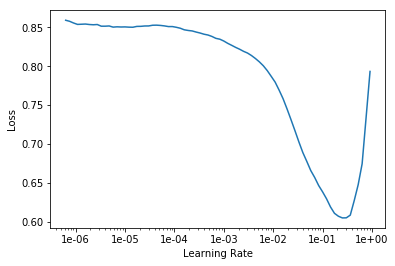

In [15]:
learn.recorder.plot()

Then we can fit the head of our network.

In [16]:
lr = 0.01

In [17]:
learn.fit_one_cycle(5, slice(lr))

Total time: 04:50
epoch  train_loss  valid_loss  accuracy_thresh  fbeta   
1      0.124402    0.107807    0.958987         0.900602  (01:02)
2      0.110674    0.099431    0.961247         0.915193  (00:56)
3      0.105607    0.093691    0.964197         0.917674  (00:57)
4      0.098209    0.089358    0.965084         0.920179  (00:57)
5      0.092631    0.087686    0.965759         0.922561  (00:57)



In [18]:
learn.save('stage-1-rn34')

...And fine-tune the whole model:

In [19]:
learn.unfreeze()

LR Finder complete, type {learner_name}.recorder.plot() to see the graph.


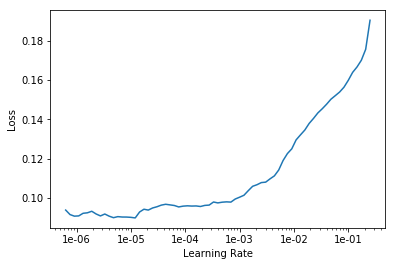

In [20]:
learn.lr_find()
learn.recorder.plot()

In [21]:
learn.fit_one_cycle(5, slice(1e-5, lr/5))

Total time: 06:37
epoch  train_loss  valid_loss  accuracy_thresh  fbeta   
1      0.097088    0.089872    0.964975         0.922765  (01:19)
2      0.096207    0.092215    0.964677         0.919122  (01:19)
3      0.094755    0.087027    0.966210         0.923074  (01:19)
4      0.088258    0.084074    0.967111         0.927760  (01:19)
5      0.083234    0.083593    0.967467         0.927519  (01:19)



In [22]:
learn.save('stage-2-rn34')

In [23]:
data = (src.datasets(ImageMultiDataset)
        .transform(tfms, size=256)
        .databunch().normalize(imagenet_stats))

learn.data = data
data.train_ds[0][0].shape

torch.Size([3, 256, 256])

In [24]:
learn.freeze()

LR Finder complete, type {learner_name}.recorder.plot() to see the graph.


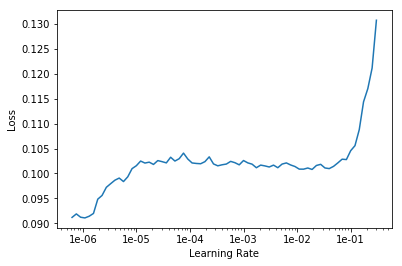

In [25]:
learn.lr_find()
learn.recorder.plot()

In [26]:
lr=1e-2/2

In [27]:
learn.fit_one_cycle(5, slice(lr))

Total time: 15:08
epoch  train_loss  valid_loss  accuracy_thresh  fbeta   
1      0.089598    0.084764    0.967104         0.925703  (03:03)
2      0.088717    0.084637    0.967395         0.926435  (03:01)
3      0.087783    0.082762    0.967961         0.927592  (03:01)
4      0.086470    0.081758    0.968121         0.929966  (03:00)
5      0.081295    0.081296    0.968652         0.929670  (03:01)



In [28]:
learn.save('stage-1-256-rn34')

In [29]:
learn.unfreeze()

In [30]:
learn.fit_one_cycle(5, slice(1e-5, lr/5))

Total time: 20:28
epoch  train_loss  valid_loss  accuracy_thresh  fbeta   
1      0.086052    0.082284    0.967830         0.928462  (04:06)
2      0.089909    0.084276    0.968223         0.926635  (04:05)
3      0.083771    0.082418    0.968230         0.928987  (04:05)
4      0.081899    0.080865    0.968412         0.930906  (04:05)
5      0.077430    0.080335    0.969131         0.931375  (04:05)



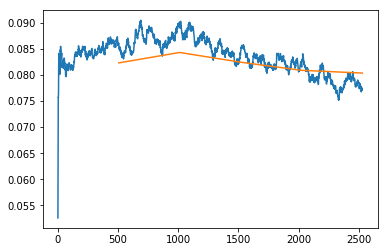

In [31]:
learn.recorder.plot_losses()

In [32]:
learn.save('stage-2-256-rn34')

You won't really know how you're going until you submit to Kaggle, since the leaderboard isn't using the same subset as we have for training. But as a guide, 100th place (out of 938 teams) on the private leaderboard was a score of `0.92895`.

## Using a test set

In [ ]:
# ! kaggle competitions download -c planet-understanding-the-amazon-from-space -f test-jpg.tar.7z -p {path}  
# ! 7za -bd -y -so x {path}/test-jpg.tar.7z | tar xf - -C {path}

 99%|███████████████████████████████████████▋| 599M/603M [00:11<00:00, 88.6MB/s]
100%|████████████████████████████████████████| 603M/603M [00:11<00:00, 53.2MB/s]


In [205]:
learn.load('stage-2-256-rn34')

In [34]:
learn.data = (src.add_test_folder('test-jpg')
        .datasets(ImageMultiDataset)
        .transform(tfms, size=256)
        .databunch().normalize(imagenet_stats))

In [36]:
out = learn.TTA()

Total time: 02:39



In [42]:
out[0][0], out[1][0]

(tensor([0.0008, 0.9992, 0.9993, 0.8051, 0.7769, 0.2548, 0.3826, 0.0024, 0.0000,
         0.0001, 0.0001, 0.0140, 0.0251, 0.0009, 0.0004, 0.0019, 0.0002]),
 tensor([0., 1., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]))

In [44]:
learn.data.test_ds

DatasetTfm(ImageMultiDataset of len 40669)

So the way things are now: if you use `.add_test_folder` you'll only *set* the new test folder in the DataBunch. Chaining calls will just set to the last one. So there are 2 ways to deal with this:
1. move all your test data to a single folder
2. run and concatenate TTA's after running on a test set.

In [58]:
subm_df = pd.read_csv(path/'sample_submission_v2.csv')

### **Aside**: looking at ways to record predictions:

In [71]:
idx2class = {v:k for k,v in learn.data.train_ds.ds.class2idx.items()}
print(idx2class)

{0: 'haze', 1: 'primary', 2: 'clear', 3: 'water', 4: 'agriculture', 5: 'cultivation', 6: 'road', 7: 'slash_burn', 8: 'cloudy', 9: 'partly_cloudy', 10: 'conventional_mine', 11: 'bare_ground', 12: 'habitation', 13: 'artisinal_mine', 14: 'blooming', 15: 'selective_logging', 16: 'blow_down'}


In [94]:
fnames = [f.name.split('.')[0] for f in learn.data.test_ds.ds.x]

In [98]:
print(fnames[:9])

['test_17412', 'test_17884', 'test_34419', 'test_31589', 'test_1133', 'test_30881', 'test_21788', 'test_456', 'test_36959']


In [103]:
out[0][1]

tensor([0.0020, 0.9745, 0.9972, 0.1394, 0.9019, 0.1849, 0.6267, 0.0033, 0.0002,
        0.0007, 0.0002, 0.0291, 0.6287, 0.0002, 0.0023, 0.0071, 0.0007])

In [135]:
tmp = out[1][0]
tmp

tensor([0., 1., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

In [129]:
classes = learn.data.test_ds.ds.classes

In [134]:
np.array(classes)[np.where(tmp.numpy().astype(np.int32)==1)]

array(['primary', 'clear', 'water', 'agriculture'], dtype='<U17')

In [147]:
np.where(tmp==1)

(array([1, 2, 3, 4]),)

In [145]:
[' '.join([idx2class[cdx] for cdx in np.where(tmp==1)[0]])]

['primary clear water agriculture']

That last one looks good.

In [ ]:
# [[' '.join([idx2class[cdx] for cdx in np.where(pred==1)[0]])] for pred in out[1]]

#### The way I did it in the last notebook:

Although this way also won't get it in one go and will crash if `subm_df` is the sample_submission file. 40k or 20k vs 60k.

In [154]:
preds = learn.get_preds(is_test=True)[0]

In [154]:
subm = np.round(preds)
fpreds = [' '.join([str(idx2class[i]) for i in np.where(subrow==1)[0]]) for subrow in subm]
fnames = [f.name for f in (path/'test-jpg-additional').ls()]

assert len(fnames) == len(fpreds)

In [216]:
subm_dict = {fname:fpred for fname,fpred in zip(fnames,fpreds)}
subm_ordering = sorted(fnames, key=lambda x: int(x.split('_')[-1].split('.')[0]))

In [222]:
subm_df.image_name = subm_ordering
subm_df.tags = [subm_dict[fname] for fname in subm_df.image_name]

### How I'll do it:

This all relies on the filenames from `learn.data.test_ds.ds.x` and the predictions from `learn.TTA()` matching up *exactly*. They do.

In [180]:
subdic = {col1:col2 for col1,col2 in zip(subm_df.image_name, subm_df.tags)}

In [182]:
def set_test_data(learner, test_folder):
    learner.data = (src.add_test_folder(test_folder)
                    .datasets(ImageMultiDataset)
                    .transform(tfms, size=256)
                    .databunch().normalize(imagenet_stats))

In [206]:
# # accidentally running on the validation set
# set_test_data(learn, 'test-jpg')
# preds = learn.TTA() # `ds_type=learn.data.test_ds` doesn't change anything

Total time: 02:39



run TTA on 1st portion of test set

In [212]:
set_test_data(learn, 'test-jpg')
raw_preds = learn.TTA(ds_type=DatasetType.Test)

Total time: 12:12



In [213]:
raw_preds[0].shape

torch.Size([40669, 17])

In [224]:
preds = copy(raw_preds)

In [226]:
fnames = [f.name.split('.')[0] for f in learn.data.test_ds.ds.x]

run TTA on 2nd portion of test set

In [228]:
set_test_data(learn, 'test-jpg-additional')
raw_preds = learn.TTA(ds_type=DatasetType.Test)

Total time: 06:16



See PyTorch forums: [How to concatenate list of pytorch tensors](https://discuss.pytorch.org/t/how-to-concatenate-list-of-pytorch-tensors/1350/2?u=wnixalo)

In [247]:
# its a tuple so I have to reassign the whole thing
preds = (torch.cat((preds[0], raw_preds[0])), torch.cat((preds[1], raw_preds[1])))

In [249]:
len(preds), preds[0].shape, preds[1].shape

(2, torch.Size([61191, 17]), torch.Size([61191, 17]))

In [269]:
fnames.extend([f.name.split('.')[0] for f in learn.data.test_ds.ds.x])

Finally assign all multiclass predictions to their corresponding filenames in the submission dataframe:

In [270]:
for i,fn in enumerate(fnames):
    subdic[fn] = ' '.join(idx2class[cdx] for cdx in np.where(preds[1][i]==1)[0])
    
subm_col = [subdic[fn] for fn in subm_df.image_name]
subm_df.tags = subm_col

## Testing test predictions

Unfortunately, the ResNet34 model is predicting the same thing for all classes.

In [283]:
np.unique(subm_df.tags.values)

array(['haze primary'], dtype=object)

But, I saw this in the last notebook. We can adjust the threshold to tune what classes get through. Instead of checking if `preds[1]` is '1', we can check if the actual activation value, `preds[0]`, is at or above the threshold we set.

In [284]:
th = 0.3

for i,fn in enumerate(fnames):
    subdic[fn] = ' '.join(idx2class[cdx] for cdx in np.where(preds[0][i]>=th)[0])
    
subm_col = [subdic[fn] for fn in subm_df.image_name]
subm_df.tags = subm_col

In [288]:
np.unique(subm_df.tags.values)

array(['agriculture cloudy', 'agriculture road cloudy', 'clear agriculture', 'clear agriculture bare_ground', ...,
       'road cloudy', 'water agriculture cloudy partly_cloudy', 'water cloudy', 'water cloudy partly_cloudy'],
      dtype=object)

It looks like you can set the threshold value for the `accuracy_threshold` metric. So there should be a good way to use this to tune a good model, instead of playing with thresholds after training and testing.

In [291]:
doc(accuracy_thresh)

accuracy_thresh [source] accuracy_thresh ( y_pred : Tensor , y_true : Tensor , thresh : float = 0.5 , sigmoid : bool = True ) → Rank0Tensor 
 
 Compute accuracy when y_pred and y_true are the same size. 
 Show in docs

## Submitting predictions to Kaggle

In [293]:
(path/'submissions/').mkdir(exist_ok=True)

In [334]:
datetime.date.today()

datetime.date(2018, 11, 8)

In [333]:
import datetime
date = str(datetime.date.today()).replace('-','')
date # great, the VMs system clock is a bit forward and thinks it's tomorrow..

'20181108'

In [336]:
sub_name = f'planet_rn34_fastai_20181107_th{str(th).replace(".","-")}.csv'
subm_df.to_csv(path/'submissions/'/sub_name, index=False, )
! kaggle competitions submit -c planet-understanding-the-amazon-from-space -f {path}/submissions/{sub_name} -m "fastai 1.0.X simple; RN34; threshold="{th}

100%|██████████████████████████████████████| 2.07M/2.07M [00:01<00:00, 2.02MB/s]
Successfully submitted to Planet: Understanding the Amazon from Space

Score: 0.92319 pvt @ 260/938. Previous best: 0.92873 pvt @ 109/938.

### playing with thresholds

In [347]:
th = 0.25

In [348]:
for i,fn in enumerate(fnames):
    subdic[fn] = ' '.join(idx2class[cdx] for cdx in np.where(preds[0][i]>=th)[0])
    
subm_col = [subdic[fn] for fn in subm_df.image_name]
subm_df.tags = subm_col

In [349]:
sub_name = f'planet_rn34_fastai_20181107_th{str(th).replace(".","-")}.csv'
subm_df.to_csv(path/'submissions/'/sub_name, index=False, )
! kaggle competitions submit -c planet-understanding-the-amazon-from-space -f {path}/submissions/{sub_name} -m "fastai 1.0.X simple; RN34; threshold="{th}

100%|██████████████████████████████████████| 2.14M/2.14M [00:00<00:00, 2.96MB/s]
Successfully submitted to Planet: Understanding the Amazon from Space

Threshold |Private Score |Rank
-|-|-
0.35|0.91826|
0.3|0.92319|260/938
0.25|0.92476|237/938
0.2|0.92324|–––––––
0.1|0.89806|


## fin